In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6

In [2]:
from matplotlib import pyplot as plt

import torch

from omegaconf import OmegaConf
from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9
from tqdm import tqdm
import ase

from morered.datasets import QM9Filtered, QM7X
from morered.noise_schedules import PolynomialSchedule
from morered.processes import VPGaussianDDPM
from morered.utils import scatter_mean, check_validity, generate_bonds_data, batch_center_systems
from morered.sampling import DDPM, MoreRedJT, MoreRedAS, MoreRedITP, ProbabilityFlowEuler, ProbabilityFlowHeun

# Structure Generation/Denoising tutorial

This notebook explains how to use the models, for structure relaxation/denoising or generation from scratch, after training. You can find pre-trained models in under "models/" directory.

## 1. Define sampler
How to instantiate the different samplers.

## 2. Define data loader
How to load data from ase.db database. 

## 3. Relaxating batches of diffused data
How to diffuse a batch of structures and denoise them using the different models.

## 4. Load your own xyz file
How to load molecules from your own xyz files and denoise them.

## 5. Sample from scratch
How to sample new stuctures from scratch given an atomic composition.

# Helper functions

In [3]:
def plot_batch_molecules(batch):
    n_cols = len(batch[properties.idx_m].unique())
    n_rows = 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        mask = batch[properties.idx_m] == i
        mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

        plot_atoms(mol, ax)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Paths

In [4]:
# path to store the dataset as ASE '.db' files
split_file_path = "split.npz"

# model path
models_path = "../models"

# Load models

In [5]:
# MoreRed-JT: joint denoiser and time predictor
morered_jt = torch.load(os.path.join(models_path, "qm9_morered_jt.pt"), map_location="cpu")

# MoreRed-AS, MoreRed-ITP and plain DDPM use the same denoier model
ddpm_denoiser = torch.load(os.path.join(models_path, "qm9_ddpm.pt"), map_location="cpu")

# Seperate model for time prediction for MoreRed-AS and MoreRed-ITP
time_predictor = torch.load(os.path.join(models_path, "qm9_time_predictor.pt"), map_location="cpu")

/tmp/ipykernel_377907/556669235.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  morered_jt = torch.load(os.path.join(models_path, "qm9_morered_jt.pt"), map_location="cpu

# Define sampler

In [6]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
diff_proc = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

In [7]:
ddpm_sampler = DDPM(
    diff_proc,
    ddpm_denoiser,
    time_key="t",
    noise_pred_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

In [8]:
mrd_jt_sampler = MoreRedJT(
    diff_proc,
    morered_jt,
    noise_pred_key="eps_pred",
    time_key="t",
    time_pred_key="t_pred",
    convergence_step=0,
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [9]:
mrd_as_sampler = MoreRedAS(
    diff_proc,
    ddpm_denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_pred_key="t_pred",
    time_key="t",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [10]:
mrd_itp_sampler = MoreRedITP(
    diff_proc,
    ddpm_denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_pred_key="t_pred",
    time_key="t",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [11]:
euler_sampler = ProbabilityFlowEuler(
    diff_proc,
    ddpm_denoiser,
    time_key="t",
    noise_pred_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

In [12]:
heun_sampler = ProbabilityFlowHeun(
    diff_proc,
    ddpm_denoiser,
    time_key="t",
    noise_pred_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

# Define data loader

Define paths

In [13]:
tut_path = "./tut"

In [14]:
os.makedirs(tut_path, exist_ok=True)

Define data input transformations

In [15]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

Define dataset

QM9

In [16]:
# path to store the dataset as ASE '.db' files
datapath = os.path.join(tut_path, "qm9.db")

In [17]:
data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    remove_uncharacterized=True,
    num_train=3000,
    num_val=3000,
    num_test=3000,
    transforms=transforms,
    num_workers=2,
    pin_memory=False,
)

QM7X

NOTE! QM7-X is large. Therefore, it takes time to download the dataset and prepare it

In [18]:
# path to store the dataset as ASE '.db' files
# datapath = os.path.join(tut_path, "qm7x.db")

In [19]:
# data = QM7X(
#     datapath=datapath,
#     only_equilibrium=False,
#     batch_size=8,
#     transforms=transforms,
#     num_train=128,
#     num_val=128,
#     num_test=128,
#     num_workers=2,
#     pin_memory=False,
#     load_properties=["rmsd"],
# )

Prepare dataset

In [20]:
# prepare and setup the dataset
data.prepare_data()
data.setup()

# Relaxing batches of diffused data

Load a batch

In [21]:
# train split here is not the same as during training
batch = next(iter(data.train_dataloader()))

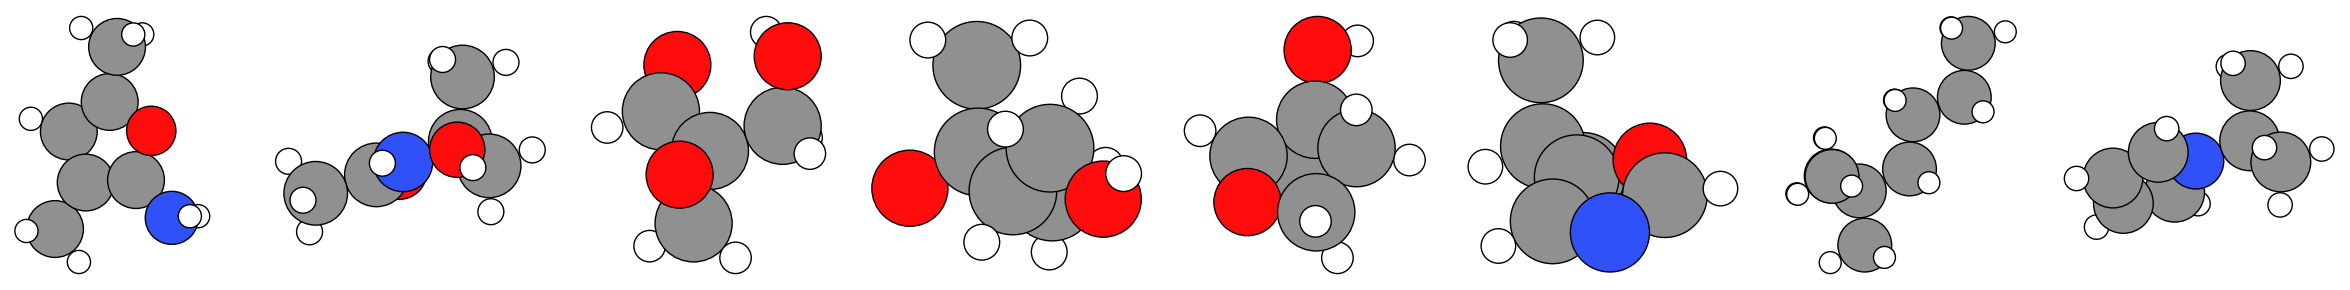

In [22]:
plot_batch_molecules(batch)

### Diffuse the batch

In [23]:
# define the time step
t = 150

In [24]:
batch[properties.R], _ = diff_proc.diffuse(batch[properties.R], batch[properties.idx_m], t=torch.tensor(t))

In [25]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-5).all()

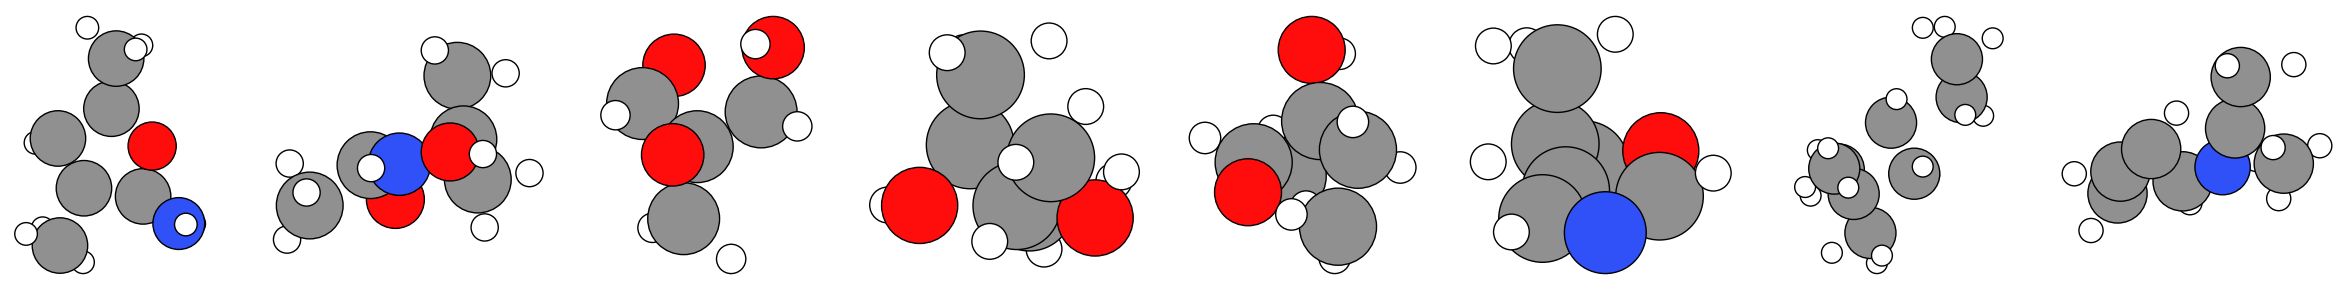

In [26]:
plot_batch_molecules(batch)

### Denoise

In [27]:
# # ddpm require time step as input
relaxed_ddpm, num_steps_ddpm, hist_ddpm = ddpm_sampler.denoise(batch, t=t)

# morered models dont need time step as input but max steps to interrupt the denoising process
relaxed_jt, num_steps_jt, hist_jt = mrd_jt_sampler.denoise(batch, max_steps=1000)
relaxed_as, num_steps_as, hist_as = mrd_as_sampler.denoise(batch, max_steps=1000)
relaxed_itp, num_steps_itp, hist_itp = mrd_itp_sampler.denoise(batch, max_steps=1000)
relaxed_euler, num_steps_euler, hist_euler = euler_sampler.denoise(batch, t=t)
relaxed_heun, num_steps_heun, hist_heun = heun_sampler.denoise(batch, t=t)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:12<00:00, 11.77it/s]
1000it [01:27, 11.39it/s]
1000it [02:50,  5.85it/s]
176it [00:15, 11.48it/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.80it/s]


In [28]:
print("Num steps per example DDPM: ", num_steps_ddpm)
print("Num steps per example MoreRed-JT: ", num_steps_jt)
print("Num steps per example MoreRed-AS: ", num_steps_as)
print("Num steps per example MoreRed-ITP: ", num_steps_itp)
print("Num steps per example Euler-ODE: ", num_steps_euler)
print("Num steps per example Heun-ODE: ", num_steps_heun)

Num steps per example DDPM:  tensor([150, 150, 150, 150, 150, 150, 150, 150])
Num steps per example MoreRed-JT:  tensor([ -1,  -1, 142,  -1,  -1,  -1,  -1,  -1])
Num steps per example MoreRed-AS:  tensor([-1, -1, -1, -1, -1, -1, -1, -1])
Num steps per example MoreRed-ITP:  tensor([137, 134, 148, 144, 135, 141, 175, 176])
Num steps per example Euler-ODE:  tensor([150, 150, 150, 150, 150, 150, 150, 150])
Num steps per example Heun-ODE:  tensor([150, 150, 150, 150, 150, 150, 150, 150])


DDPM:


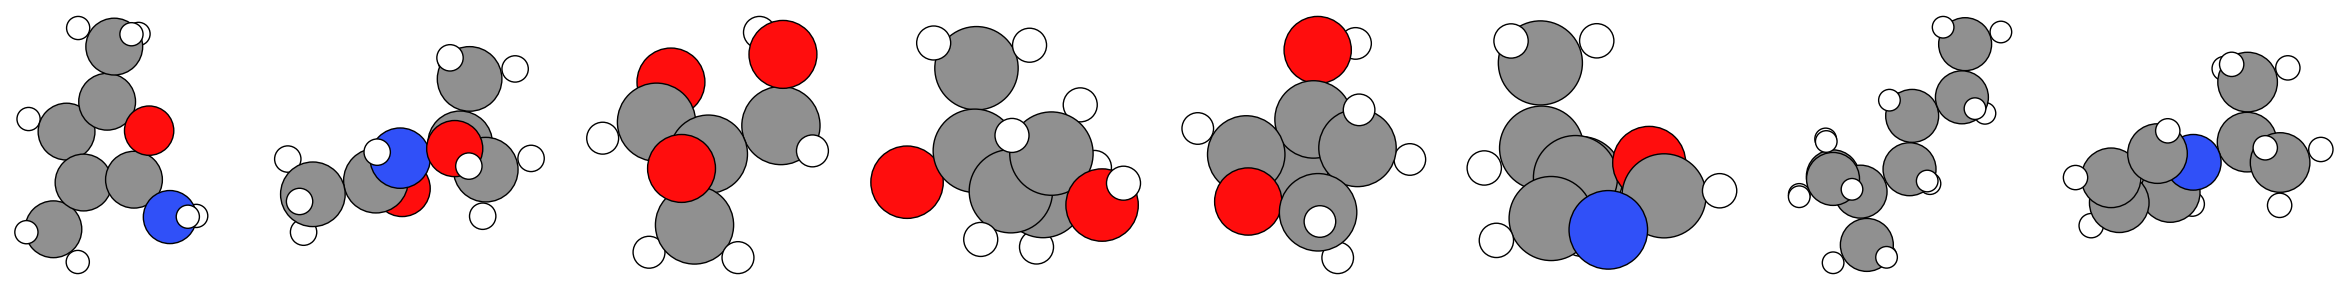

MoreRed-JT:


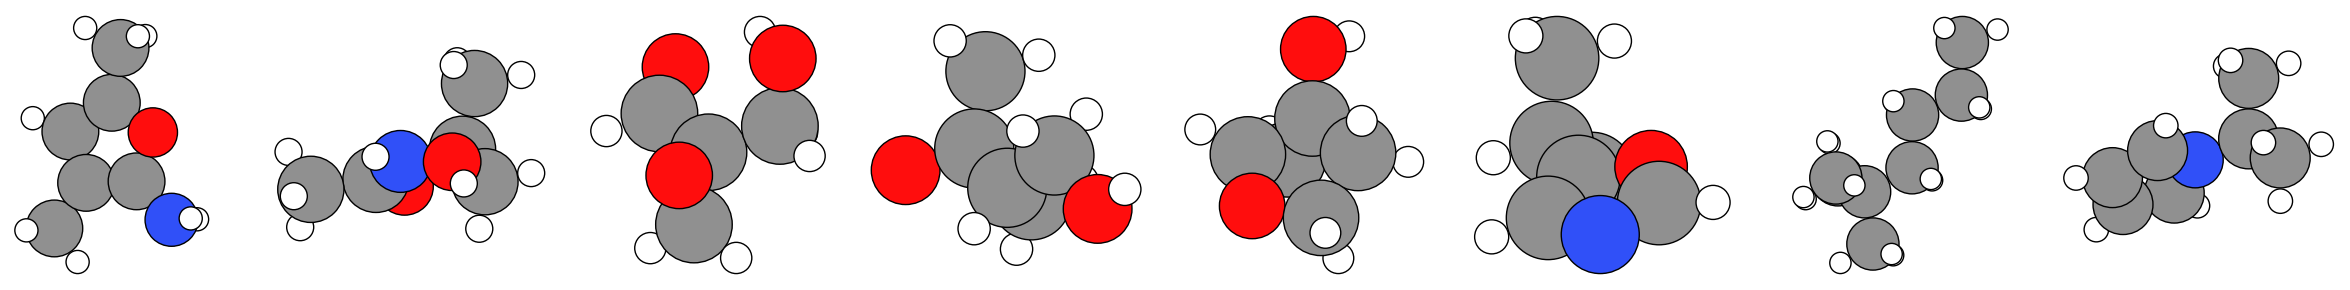

MoreRed-AS:


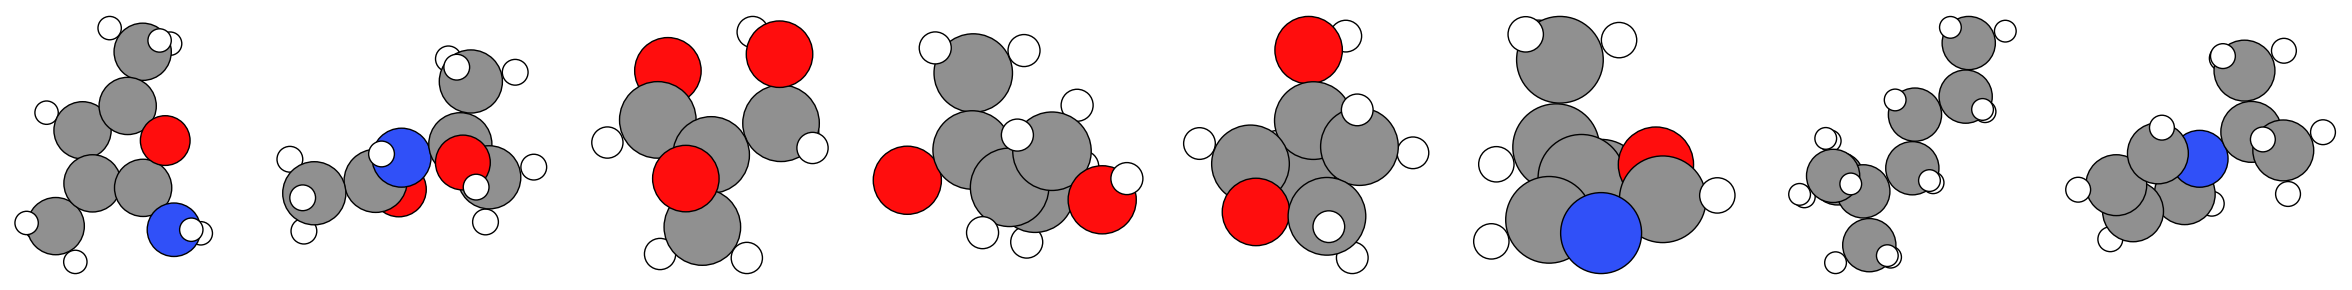

MoreRed-ITP:


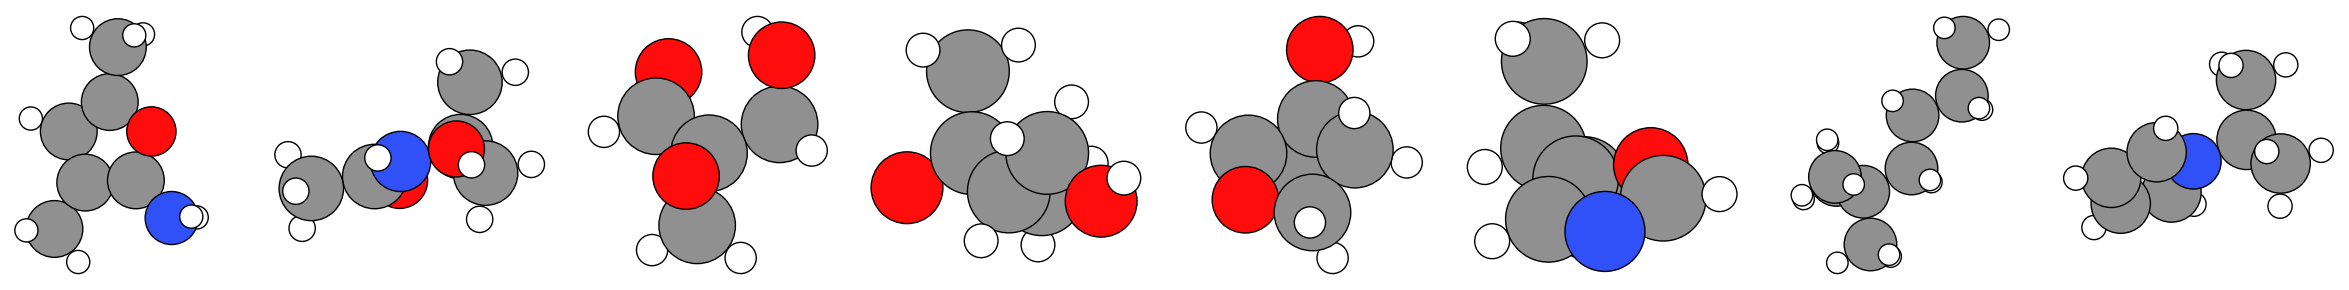

Euler-ODE:


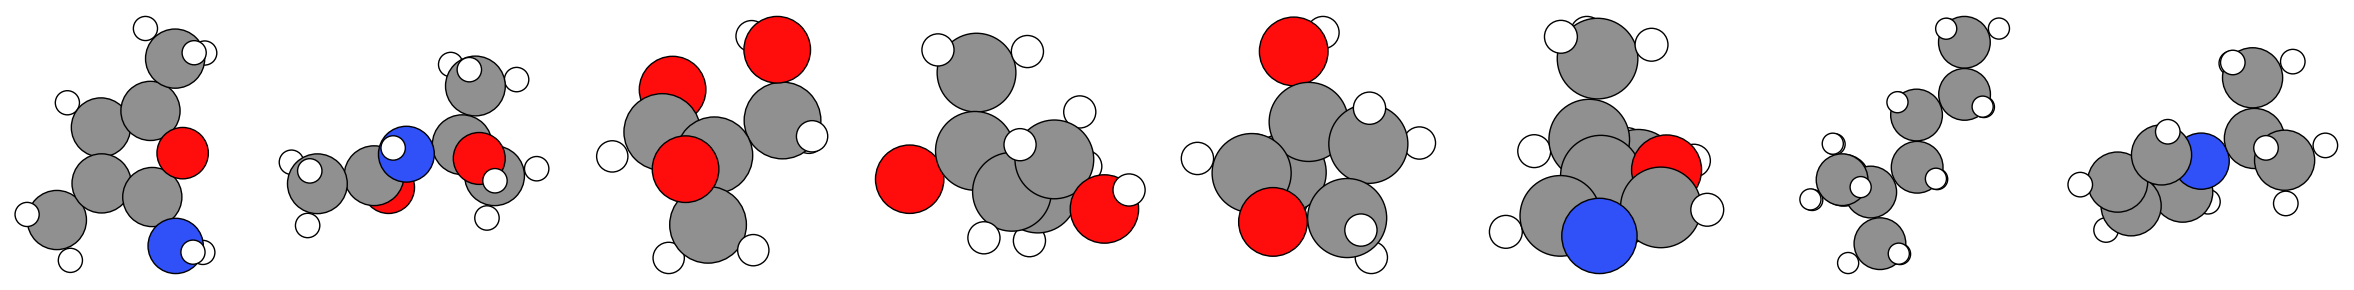

Heun-ODE:


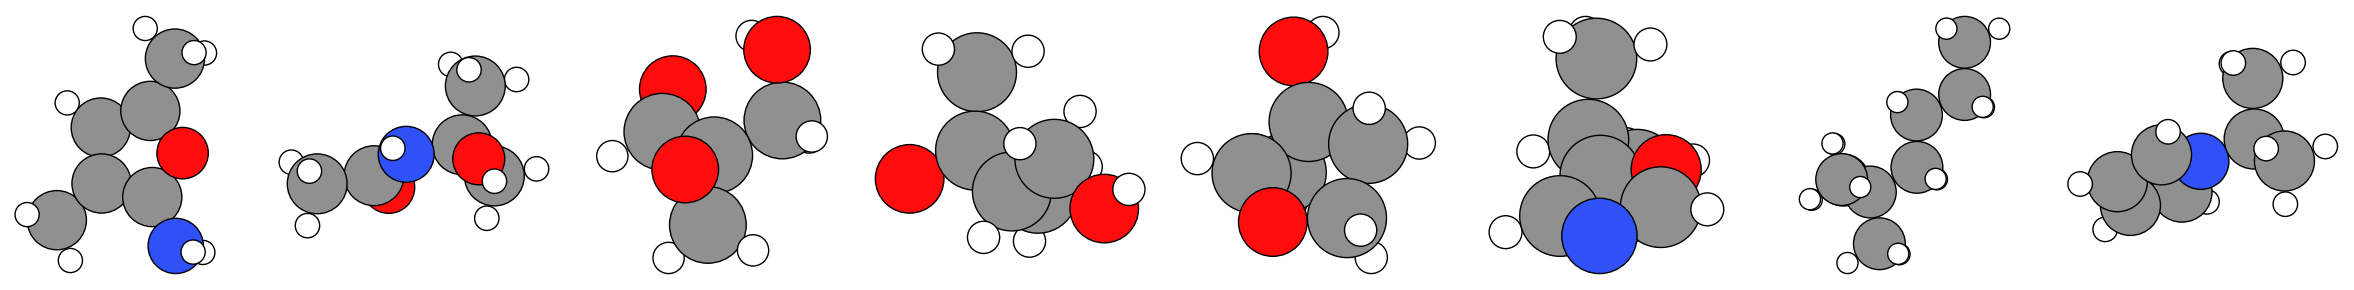

In [29]:
# plot the different examples
tmp_batch = {key: val.clone() for key, val in batch.items()}

print("DDPM:")
tmp_batch.update(relaxed_ddpm)
plot_batch_molecules(tmp_batch)

print("MoreRed-JT:")
tmp_batch.update(relaxed_jt)
plot_batch_molecules(tmp_batch)

print("MoreRed-AS:")
tmp_batch.update(relaxed_as)
plot_batch_molecules(tmp_batch)

print("MoreRed-ITP:")
tmp_batch.update(relaxed_itp)
plot_batch_molecules(tmp_batch)

print("Euler-ODE:")
tmp_batch.update(relaxed_euler)
plot_batch_molecules(tmp_batch)

print("Heun-ODE:")
tmp_batch.update(relaxed_heun)
plot_batch_molecules(tmp_batch)

In [30]:
# check validity of the molecules for each method
# Note this is just a simple check that can't e.g. recognize aromatic rings, check cG-SchNet Gebauer et al. for the analysis scripts

bonds_data = generate_bonds_data().values()

tmp_batch.update(relaxed_ddpm)
validity_ddpm = check_validity(tmp_batch, *bonds_data)
print("Validity DDPM: ", validity_ddpm['stable_molecules'])

tmp_batch.update(relaxed_jt)
validity_jt = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-JT: ", validity_jt['stable_molecules'])

tmp_batch.update(relaxed_as)
validity_as = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-AS: ", validity_as['stable_molecules'])

tmp_batch.update(relaxed_itp)
validity_itp = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-ITP: ", validity_itp['stable_molecules'])

tmp_batch.update(relaxed_pf)
validity_ddpm = check_validity(tmp_batch, *bonds_data)
print("Validity Euler-ODE: ", validity_ddpm['stable_molecules'])

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2088.67it/s]


Validity DDPM:  [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1696.81it/s]


Validity MoreRed-JT:  [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1393.46it/s]


Validity MoreRed-AS:  [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1290.26it/s]


Validity MoreRed-ITP:  [np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_, np.True_]


NameError: name 'relaxed_pf' is not defined

# Load your own xyz file

In [ ]:
examp = ase.io.read("example.xyz")

batch = mrd_jt_sampler.prepare_inputs(examp)

In [ ]:
print("Before relaxation:")
plot_atoms(examp)
plt.axis("off")
plt.show()

In [ ]:
relaxed, num_steps, hist = mrd_jt_sampler.denoise(batch, max_steps=1000)

In [ ]:
examp.positions = relaxed[properties.R].numpy()

print("After relaxation:")
plot_atoms(examp)
plt.axis("off")
plt.show()

# Sample from scratch

Load a batch

In [ ]:
batch = next(iter(data.train_dataloader()))

In [ ]:
plot_batch_molecules(batch)

Sample random prior x_T from N(0,I)

In [ ]:
t = None

In [ ]:
x_T = ddpm_sampler.sample_prior(batch, t=None)

In [ ]:
batch.update(x_T)

In [ ]:
plot_batch_molecules(batch)

In [ ]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-5).all()

In [ ]:
samples_ddpm, num_steps_ddpm, hist_ddpm = ddpm_sampler.denoise(batch, t=t)

samples_jt, num_steps_jt, hist_jt = mrd_jt_sampler.denoise(batch, max_steps=2000)
samples_as, num_steps_as, hist_as = mrd_as_sampler.denoise(batch, max_steps=2000)
samples_itp, num_steps_itp, hist_itp = mrd_itp_sampler.denoise(batch, max_steps=2000)

In [ ]:
print("Num steps per example DDPM: ", num_steps_ddpm)
print("Num steps per example MoreRed-JT: ", num_steps_jt)
print("Num steps per example MoreRed-AS: ", num_steps_as)
print("Num steps per example MoreRed-ITP: ", num_steps_itp)

In [ ]:
# plot the different examples
tmp_batch = {key: val.clone() for key, val in batch.items()}

print("DDPM:")
tmp_batch.update(samples_ddpm)
plot_batch_molecules(tmp_batch)

print("MoreRed-JT:")
tmp_batch.update(samples_jt)
plot_batch_molecules(tmp_batch)

print("MoreRed-AS:")
tmp_batch.update(samples_as)
plot_batch_molecules(tmp_batch)

print("MoreRed-ITP:")
tmp_batch.update(samples_itp)
plot_batch_molecules(tmp_batch)


In [ ]:
# check validity of the molecules for each method
# Note this is just a simple check that can't e.g. recognize aromatic rings, check cG-SchNet Gebauer et al. for the analysis scripts

bonds_data = generate_bonds_data().values()

tmp_batch.update(samples_ddpm)
validity_ddpm = check_validity(tmp_batch, *bonds_data)
print("Validity DDPM: ", validity_ddpm['stable_molecules'])

tmp_batch.update(samples_jt)
validity_jt = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-JT: ", validity_jt['stable_molecules'])

tmp_batch.update(samples_as)
validity_as = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-AS: ", validity_as['stable_molecules'])

tmp_batch.update(samples_itp)
validity_itp = check_validity(tmp_batch, *bonds_data)
print("Validity MoreRed-ITP: ", validity_itp['stable_molecules'])

# Sample by manually using atomic numbers

Define the atomic numbers Z for p(X|Z)

In [ ]:
Z = [
    torch.tensor([6, 7, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1]),
    torch.tensor([6, 6, 6, 6, 8, 8, 1, 1, 1, 1, 1, 1]),
    torch.tensor([6, 6, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]),
]

Prepare the inputs

In [ ]:
batch = mrd_jt_sampler.prepare_inputs(Z)

In [ ]:
batch.keys()

In [ ]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-5).all()

In [ ]:
x_T = mrd_jt_sampler.sample_prior(batch, t=None)

In [ ]:
batch.update(x_T)

In [ ]:
plot_batch_molecules(batch)

In [ ]:
samples, num_steps, hist = mrd_jt_sampler.denoise(batch, max_steps=2000)

In [ ]:
batch.update(samples)

In [ ]:
plot_batch_molecules(batch)

# Plot Sampling trajectory

In [ ]:
time_steps = [
    item["t"] for item in hist
    
]

time_steps = torch.stack(time_steps, dim=0)

time_steps.shape

In [ ]:
plt.figure(figsize=(10, 5))

for i, traj in enumerate(time_steps.T):
    plt.plot(traj[:num_steps[i]], '-')

plt.show()

In [ ]:
i = 2

mols_traj = [ Atoms(numbers=Z[i], positions=h[properties.R][batch[properties.idx_m] == i]) for h in hist]

mols_traj = mols_traj[:num_steps[i]]

In [ ]:
# plot mols in 4*8 subplots

n_cols = 8
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()

# sample equally spaced indices
sub_traj = mols_traj[::len(mols_traj) // (n_cols * n_rows) + 1]

for i, mol in enumerate(sub_traj):
    plot_atoms(mol, axs[i])
    axs[i].axis("off")

plt.tight_layout()
plt.show()